# Workshop 5. Рекомендательная система

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [Лекция 8. Рекомендательный системы](https://www.youtube.com/watch?v=Te_6TqEhyTI&t=4s).
- [Туториал по рекомендательным системам](http://nbviewer.jupyter.org/urls/gitlab.7bits.it/isiganov/ml-course/raw/master/week05/theory/05-01-clustering.ipynb?inline=false)

- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную

В этой практике мы попробуем построить очень простую рекомендательную систему, основанную на поиске кластера похожих пользователей.  
Похожие они в том плане, что смотрят одинаковые фильмы и оценивают их приблизительно одинаково.  
Мы будем строить очень простую модель, по сути которая даже не является именно системой рекомендации, но как минимум она может быть первым шагом к ее построению: мы найдем класет похожих пользователей, узнаем какие фильмы они смотрят и одинаково любят, какие жанры предпочитают.

Лабораторная будет больше похожа на манипулции с одним большим датафреймом. Если у вас появятся интересные идеи, то можете попробовать их тоже. 

## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
anime = pd.read_csv('./anime/data_anime_anime.csv.zip', index_col='anime_id')
anime.dropna(inplace=True)
print(anime.shape)
anime.head()

(12017, 6)


,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [3]:
ratings = pd.read_csv('./anime/data_anime_rating.csv.zip')
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## Обзор данных

Постройте графики для обзора признаков: anime.type, episodes, rating, members.

Посмотрите на info по таблицам, нам важно знать сколько оперативной памяти занимает каждая таблица, так как дальше у нас будет декартово произведение таблиц и размер может вылететь за 5 гигабайт.

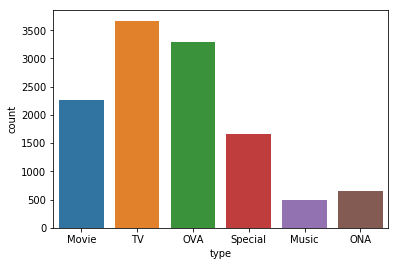

In [4]:
sns.countplot(x='type', data=anime)

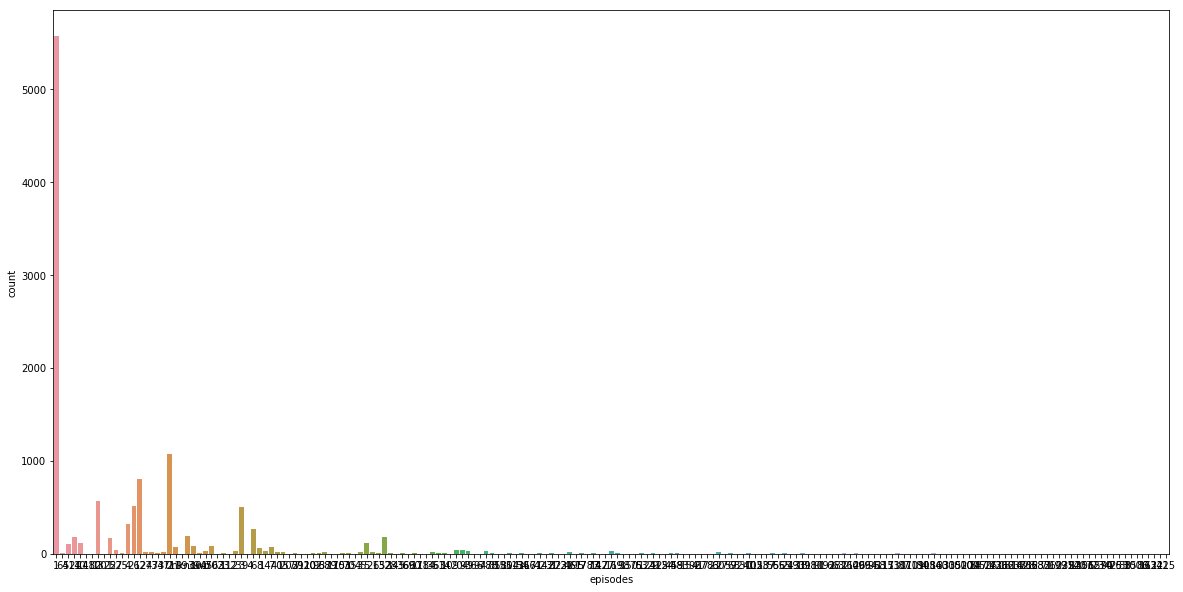

In [5]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(x='episodes', data=anime, ax=ax)

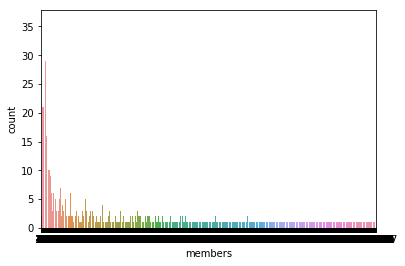

In [6]:
sns.countplot(x='members', data=anime)

In [7]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12017 entries, 32281 to 26081
Data columns (total 6 columns):
name        12017 non-null object
genre       12017 non-null object
type        12017 non-null object
episodes    12017 non-null object
rating      12017 non-null float64
members     12017 non-null int64
dtypes: float64(1), int64(1), object(4)
memory usage: 977.2+ KB


In [8]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
user_id     int64
anime_id    int64
rating      int64
dtypes: int64(3)
memory usage: 178.8 MB


## Жанры

Как в материалах к воркшопу постройте таблицу, в которой в строках будет названиефильма, а в столбцах жанр. В ячейках 1 - если в этого фильма есть такой жанр и 0 иначе.

Постройте countplot для визуализации количества фильмов каждого из жанров.

Постройте график, на котором будут изображениы распределения рейтингов по каждому из жанров. Должно получиться что-то подобное: ![Imgur](https://i.imgur.com/hyuA6ia.png)

In [9]:
from itertools import chain

def flatmap(f, items):
    return chain.from_iterable(map(f, items))

def genre_splitter(genre_names):
    return genre_names.split(", ")

a_uniq = anime['genre'].unique()
genres = set(flatmap(genre_splitter, a_uniq))
genres = sorted(list(genres))
print("Genres={}\nlen={}".format(genres, len(genres)))

Genres=['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai', 'Historical', 'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody', 'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai', 'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural', 'Thriller', 'Vampire', 'Yaoi', 'Yuri']
len=43


In [10]:
anime_genres = pd.DataFrame(index=anime.index)
anime_genres['name'] = anime['name']
for g in genres:
    anime_genres[g] = anime['genre'].str.contains(g).astype(int)
print(anime_genres.shape)

anime_genres.head(10)

(12017, 44)


,name,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
anime_id,,,,,,,,,,,,,,,,,,,,,
32281,Kimi no Na wa.,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
5114,Fullmetal Alchemist: Brotherhood,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
28977,Gintama°,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9253,Steins;Gate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9969,Gintama&#039;,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
11061,Hunter x Hunter (2011),1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
820,Ginga Eiyuu Densetsu,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


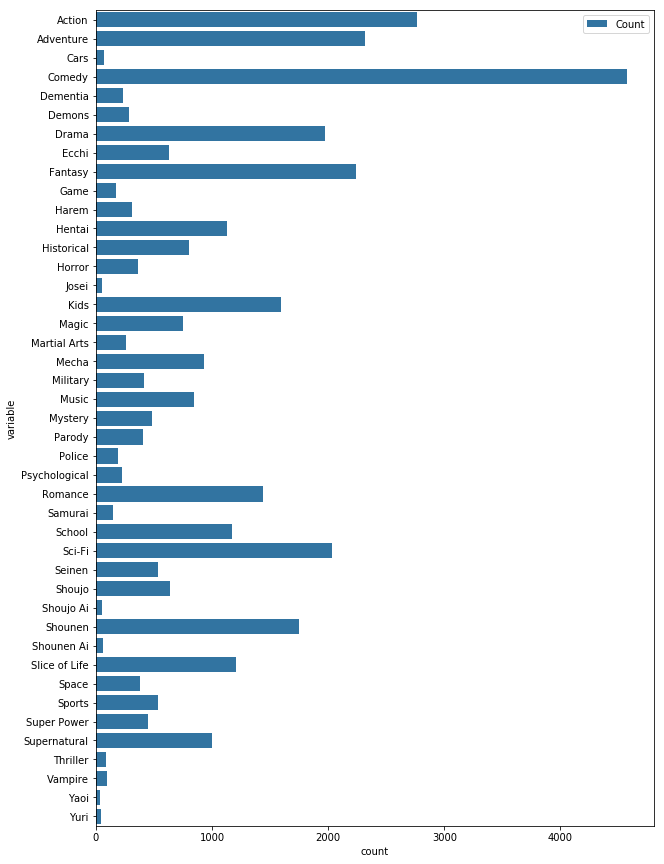

In [25]:
import matplotlib.ticker as ticker

temp = pd.melt(anime_genres[genres])

fig, ax = plt.subplots(figsize=(10, 15))
#ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=str(temp[temp['value'] == 1].max())))                      
plot = sns.countplot(y='variable', hue="value", data=temp[temp['value'] == 1], ax=ax)
handles, _ = plot.get_legend_handles_labels()
ax.legend(handles, ["Count"])

## Рейтинг

Постройте график, показывающий сколько оценок каждого рейтинга поставили пользователи из таблицы `ratings`.

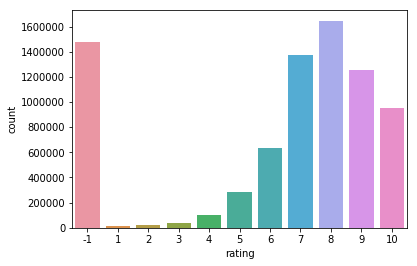

In [12]:
sns.countplot(x='rating', data=ratings)

## Фильтрация данных

Если мы сразу же построим кросстаб матрицу `anime` vs `user`, где в ячейках рейтинг, который поставил юзер этому фильму, то у нас это все займет около 6 гигабайт памяти. Можно значительно сократить размер матрицы, если выкинуть данные об аниме, которое почти никто не оценил и юзеров, которые почти ничего не оценивали.

Для этого постройте два новых датафрейма:

- anime_watches, где индексом является anime_name, а значением - количество его обзоров
- user_ratings, где индексом является user_id, а значением - количество вниме, которое он оценил.

Далее, соедините (join) 4 таблицы: ratings, anime, anime_watches, user_ratings и назовите новую таблицу anime_ratings.

Что означает `-1` в таблице рейтинга? Замените все -1 на средний рейтинг аниме.

Удалите из таблицы все те значения, у которых количество обзоров и рейтингов меньше медианного значения. То есть мы удалим половину аниме и половину юзеров.

In [13]:
#anime_watches = pd.DataFrame(index=anime['name'])
#for index in anime_watches.index:
    #anime_watches[index] = 0
#anime_watches.head(5)

## Матрица user-item

Превратите таблицу anime_ratings в матрицу, где в строках user_id, в стобцах anime_name, а в ячейках рейтинг. Посмотрите сколько занимет в памяти эта матрица.

## Понижение размерности

kNN будет плохо работать на многомерных данных, поэтому надо понизить размерности матрицы с помощью алгоритма PCA. Количество размерностей установите от 4 до 10 - как вам покажется оптимальнее. (можете это исправить когда запустите kNN и получите результаты).

## Обучение kNN

Обучим kNN, чтобы он нашел нам центры кластеров нашей выборки.

Так как в строках у нас user_id, то центры класетров - это будут характеристики пользователей в терминах их оценок аниме. Используя эту информацию мы можем вычислить список характерных аниме для конкретного кластера.

- обучите kNN
- создайте копию матрицы и добавьте новую колонку - кластер. Положите в нее результат предсказания кластера для каждого пользователя. (метод predict)
- нарисуйте cout plot количества юзеров в каждом кластере. Если получается сильно неравномерное распределение, то вам надо подобрать другое количество кластеров или изменить размерность в предыдущем шаге.

## Top 15 аниме

Найдем Top-15 аниме для каждого кластера. Для этого:

- найдите средний рейтинг аниме в каждом кластере. 
- для каждого кластера возьмите набор аниме с их средним рейтингом, отсортируйте этот набор по убыванию рейтинга. 
- возьмите первые 15 элементов из набора - это и будет топ15 аниме в кластере.
- согласны ли вы с содержимым кластера?

## Top 5 жанров

Если соеднить таблицу с аниме с таблицей жанров, то можно найти топ жанров для каждого кластера. Придумайте сами как это сделать, так как тут много способов:

- найти средний рейтинг для аниме каждого жанра
- посчитать сколько представителей каждого жанра есть среди top100 аниме кластера (кстати работает лучше)
- ???